# Get dataset

In [13]:
import os
import glob
import string
import unicodedata


In [14]:


all_letters = string.ascii_letters + ".;,'"
n_letters = len(all_letters)

def findFiles(path) -> list:
    return glob.glob(path)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
    
def extract_from_file(path):
    f = open(path, 'r', encoding='utf-8')
    names = f.read().strip().split('\n')
    return names


In [15]:
category_lines = {}
all_categories = []

file_pathes = findFiles('data/names/*.txt')
for path in file_pathes:
    category = os.path.splitext(os.path.basename(path))[0]
    all_categories.append(category)
    lines = extract_from_file(path)
    category_lines[category] = lines
n_categories = len(all_categories)



In [16]:
all_categories

['Polish',
 'Spanish',
 'English',
 'Irish',
 'German',
 'Chinese',
 'Greek',
 'Italian',
 'Vietnamese',
 'Czech',
 'Korean',
 'French',
 'Dutch',
 'Arabic',
 'Scottish',
 'Portuguese',
 'Japanese',
 'Russian']

In [17]:
for key, value in category_lines.items():
    print(f'{key}: {len(value)}')

Polish: 139
Spanish: 298
English: 3668
Irish: 232
German: 724
Chinese: 268
Greek: 203
Italian: 709
Vietnamese: 73
Czech: 519
Korean: 94
French: 277
Dutch: 297
Arabic: 2000
Scottish: 100
Portuguese: 74
Japanese: 991
Russian: 9408


# Turning Names into Tensors

In [18]:
import torch

timesteps = 1

def letterToIndex(letter) -> int:
    return all_letters.find(letter)

# output: <1 x n_letters>
def letterToTensor(letter) -> torch.Tensor:
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# output: <line length x 1 x n_letters> <=> (timesteps, batch size, feature size)
def lineToTensor(line) -> torch.Tensor:
    tensor = torch.zeros(len(line), timesteps, n_letters)
    for idx, letter in enumerate(line):
        tensor[idx][0][letterToIndex(letter)] = 1
    return tensor



In [19]:

tensor_line = lineToTensor('letter')

In [20]:
print(tensor_line.shape)
tensor_line

torch.Size([6, 1, 56])


tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0

In [34]:
import torch.nn as nn
from model import RNNFromScratch

n_hidden = 128

# class ClassifierRNNs(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(ClassifierRNNs, self).__init__()

#         self.hidden_size = hidden_size
#         self.W_hx = nn.Linear(input_size, hidden_size)
#         self.W_hh = nn.Linear(hidden_size, hidden_size)
#         self.W_oh = nn.Linear(hidden_size, output_size)
#         self.softmax = nn.LogSoftmax(dim=1)
    
#     def forward(self, input, hidden):
#         W_hx_x = self.W_hx(input)
#         hidden = self.W_hh(hidden + W_hx_x)
#         output = self.W_oh(hidden)
#         y_hat = self.softmax(output)

#         return y_hat, hidden
    
#     def initHidden(self):
#         return torch.zeros(1, self.hidden_size)

rnn = RNNFromScratch(input_size=n_letters, hidden_size=n_hidden, output_size=n_categories)

In [32]:
input_line = lineToTensor('Aiden')
hidden = torch.zeros(1, n_hidden)
# 만약 맡에 코드처럼 input_line[0] 이렇게 안 하고 즉 batch size=1로 하지 않고 batch size=line length로 하면 hidden은 어떻게 update?
# hidden states가 여러개 생성되며 tensor로 관리된다.
y_hat, next_line_hidden = rnn(input_line, hidden)

In [33]:
y_hat

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]],
       grad_fn=<LogSoftmaxBackward0>)

In [24]:
def categoryFromOutput(output):
    top_v, top_i = output.topk(1)
    category_i = top_i.item()
    category = all_categories[category_i]
    return category, category_i

In [25]:
import random

def randomChoice(list):
    return list[random.randint(0, len(list)-1)]

def getTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [26]:
for _ in range(10):
    category, line, category_tensor, line_tensor = getTrainingExample()
    print(f"Category: {category} / Line: {line} / category tensor: {category_tensor}")

Category: Greek / Line: Theohari / category tensor: tensor([6])
Category: French / Line: Cloutier / category tensor: tensor([11])
Category: Chinese / Line: Tian / category tensor: tensor([5])
Category: Dutch / Line: Veen / category tensor: tensor([12])
Category: German / Line: Wedekind / category tensor: tensor([4])
Category: Korean / Line: Hwang / category tensor: tensor([10])
Category: Chinese / Line: Cui / category tensor: tensor([5])
Category: Polish / Line: Szwarc / category tensor: tensor([0])
Category: Chinese / Line: Chao / category tensor: tensor([5])
Category: Chinese / Line: Hor / category tensor: tensor([5])


In [27]:
model = RNNFromScratch(input_size=n_letters, hidden_size=n_hidden, output_size=n_categories)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

def train(line_tensor, category_tensor):
    hidden = model.initHidden()
    model.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step()

    # for p in model.parameters():
    #     p.data.add_(p.grad.data, alpha=-learning_rate)
    
    return output, loss.item() # number

In [28]:
import time
import math

epochs = 100000
every_print = 5000
every_plot = 1000

def timeSince(since) -> string:
    now = time.time()
    duration = now - since
    minute = math.floor(duration / 60)
    sec = duration - minute * 60

    return '{} : {}'.format(minute, math.floor(sec))


In [29]:
all_losses = []
current_loss = 0
start = time.time()

for epoch in range(epochs+1):
    category, line, category_tensor, line_tensor = getTrainingExample()
    
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss

    if epoch % every_print == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / epochs * 100, timeSince(start), loss, line, guess, correct))

    if epoch % every_plot == 0:
        all_losses.append(current_loss / every_plot)
        current_loss = 0


0 0% (0 : 0) 2.7700 Gentile / Czech ✗ (Italian)
5000 5% (0 : 9) 293.0579 Furlan / Dutch ✗ (Italian)
10000 10% (0 : 18) 41847.3789 Amalberti / Irish ✗ (Italian)
15000 15% (0 : 31) 5129.9390 Davidson / Portuguese ✗ (Scottish)
20000 20% (0 : 46) 22.4117 Gim / Dutch ✗ (Chinese)
25000 25% (0 : 58) 4.0269 Joe / Vietnamese ✗ (Chinese)
30000 30% (1 : 14) 14443.3838 Cingolani / Greek ✗ (Italian)
35000 35% (1 : 31) 229.7466 Simon / Polish ✗ (French)
40000 40% (1 : 48) 5757.8540 Jakovchuk / Japanese ✗ (Russian)
45000 45% (2 : 3) 1281185.8750 Giannakopoulos / Japanese ✗ (Greek)
50000 50% (2 : 13) 6477.1934 Modugno / Portuguese ✗ (Italian)
55000 55% (2 : 24) 19.4509 Górka / German ✗ (Polish)
60000 60% (2 : 35) 219.2374 Soucek / Dutch ✗ (Czech)
65000 65% (2 : 48) 1471.3115 Kaglantge / Japanese ✗ (Greek)
70000 70% (3 : 2) 0.0000 Bhrighde / Irish ✓
75000 75% (3 : 13) 871.9937 Colley / Portuguese ✗ (English)
80000 80% (3 : 26) 161.9813 Jeon / Russian ✗ (Korean)
85000 85% (3 : 39) 9549.9043 Murkami / Po

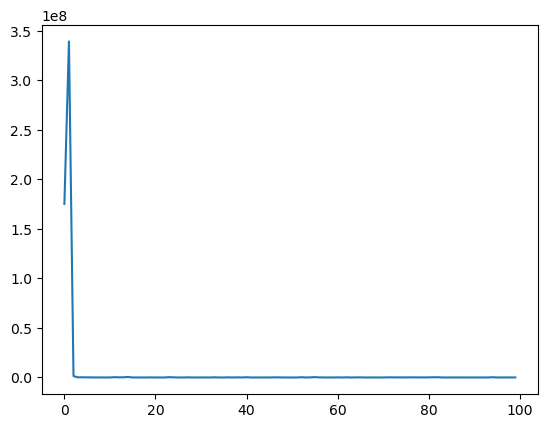

In [30]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses[1:])